In [3]:
from nnsight import NNsight
import torch 
from transformers import GPTJForCausalLM, AutoTokenizer 
from IPython.display import clear_output
from nnsight import LanguageModel
from typing import List, Callable
import torch
import numpy as np
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from lmm_synthetic.mm_train.gptj_vlm import GPTJ_VLM



model_path = "/data/lmm/checkpoints/checkpoint-1953"
gptj = GPTJForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = LanguageModel(gptj,tokenizer=tokenizer)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)
model.eval()

/home/sjoshi/anaconda3/envs/vlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50257, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTJBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (out_proj): Linear(in_features=768, out_features=768, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=768, out_features=3072, bias=True)
          (fc_out): Linear(in_features=3072, out_features=768, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((7

In [6]:
prompts = ["""| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 
""",
"""| bird | bird | bird |
| deer | bird | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 
""",
"""| airplane | airplane | airplane |
| deer | airplane | cat |
| airplane | dog | airplane |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'airplane', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 
"""]

def preds_over_layers(data, annotations, token_num):
    for pred, prob in zip([row[token_num].strip().split(" ")[0] for row in annotations], data[:, token_num]):
        print(f"{pred}, {prob:.2f}")

def probs_over_answers(probs, tokens):
    token_ids = {token: tokenizer.encode(f" {token}", add_special_tokens=False)[0] for token in tokens}
    # Extract probabilities for the specified token IDs
    token_probs = probs[:, -1, [token_ids[token] for token in tokens]]
    # Convert to numpy array for easier manipulation
    token_probs_np = token_probs.detach().cpu().numpy()
    
    # Create a mask for the maximum values in each row
    max_mask = (token_probs_np == token_probs_np.max(axis=1, keepdims=True))
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    yticklabels = [f'Layer {i//2} {"attn" if i % 2 == 0 else "mlp"}' for i in range(token_probs_np.shape[0])]
    ax = sns.heatmap(token_probs_np, 
                     xticklabels=tokens, 
                     yticklabels=yticklabels, 
                     cmap='viridis', 
                     annot=True,
                     fmt=".2f",
                     linewidths=0.5,
                     linecolor='black')
    
    # Add red outline around the maximum values in each row
    for y in range(token_probs_np.shape[0]):
        for x in range(token_probs_np.shape[1]):
            if max_mask[y, x]:
                ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=3))
    
    plt.xlabel('Tokens')
    plt.ylabel('Layers')
    plt.title('Average Probabilities over Layers for Each Token')
    plt.show()
    
    
def access_prompt (prompt_index, row, column):
    return prompts[prompt_index].format(row=row, column=column)

ANIMALS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def logit_look(prompt_index, row, column, print_prompt=True, plot=True):
    prompt = access_prompt(prompt_index, row, column)
    
    if print_prompt:
        print(prompt)
    layers = model.transformer.h

    probs_layers = []

    with model.trace() as tracer:
        with tracer.invoke(prompt) as invoker:
            for layer_idx, layer in enumerate(layers):
                # Process layer output through the model's head and layer normalization
                attn_output = model.lm_head(model.transformer.ln_f(layer.attn.output[0]))
                mlp_output = model.lm_head(model.transformer.ln_f(layer.output[0]))

                # Apply softmax to obtain probabilities and save the result
                attn_probs = torch.nn.functional.softmax(attn_output, dim=-1).save()
                mlp_probs = torch.nn.functional.softmax(mlp_output, dim=-1).save()
                probs_layers.append(attn_probs)
                probs_layers.append(mlp_probs)

    probs = torch.cat([probs.value for probs in probs_layers])
    probs = probs[:,:64,:]
    probs_over_answers(probs, ANIMALS)
    
    
    # Find the maximum probability and corresponding tokens for each position
    max_probs, tokens = probs.max(dim=-1)
    # Decode token IDs to words for each layer
    words = [[model.tokenizer.decode(t.cpu()).encode("unicode_escape").decode() for t in layer_tokens]
        for layer_tokens in tokens]
    print(tokens[11][-1].item(), words[11][-1])
    # Access the 'input_ids' attribute of the invoker object to get the input words
    input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

    data = max_probs.detach().cpu().numpy()[:, :64]  
    cutoff = [layer[:64] for layer in words]  

    annotations = []
    for layer_idx, layer_words in enumerate(cutoff):  
        annotation_layer = []
        for token_idx, word in enumerate(layer_words): 
            prob = data[layer_idx, token_idx]
            annotation_layer.append(f"{word} \n {prob * 100:.4f}%")
        annotations.append(annotation_layer)  

    if plot:
        plt.figure(figsize=(128, 12))  

        ax = sns.heatmap(data,  # Only show the last column
                        annot=annotations,  # Only annotate the last column
                        fmt='s',
                        cmap='coolwarm',
                        annot_kws={"size": 10},
                        cbar_kws={'label': 'Probability'},
                        cbar=True,
                        )


        plt.xlabel("Input Tokens", fontsize=30)  
        plt.ylabel("Layers", fontsize=30)  

        ax.set_xticks([x + 0.5 for x in range(len(input_words[:64]))])  
        ax.set_xticklabels(input_words[:64], fontsize=20, ha='center')  

        plt.yticks(rotation=0, fontsize=30)  

        plt.savefig("logit_lens_plot.png", dpi=75, bbox_inches='tight')
        plt.show()
    
    if print_prompt:
        print(f"Model predicts{data[-1][-1] * 100 : 4f}% chance answer is{cutoff[-1][-1]}")
    
    preds_over_layers(data, annotations, -1)

| airplane | airplane | airplane |
| deer | airplane | cat |
| airplane | dog | airplane |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'airplane', 'dog', 'cat'].
What object is in row 1, column 2? A: 



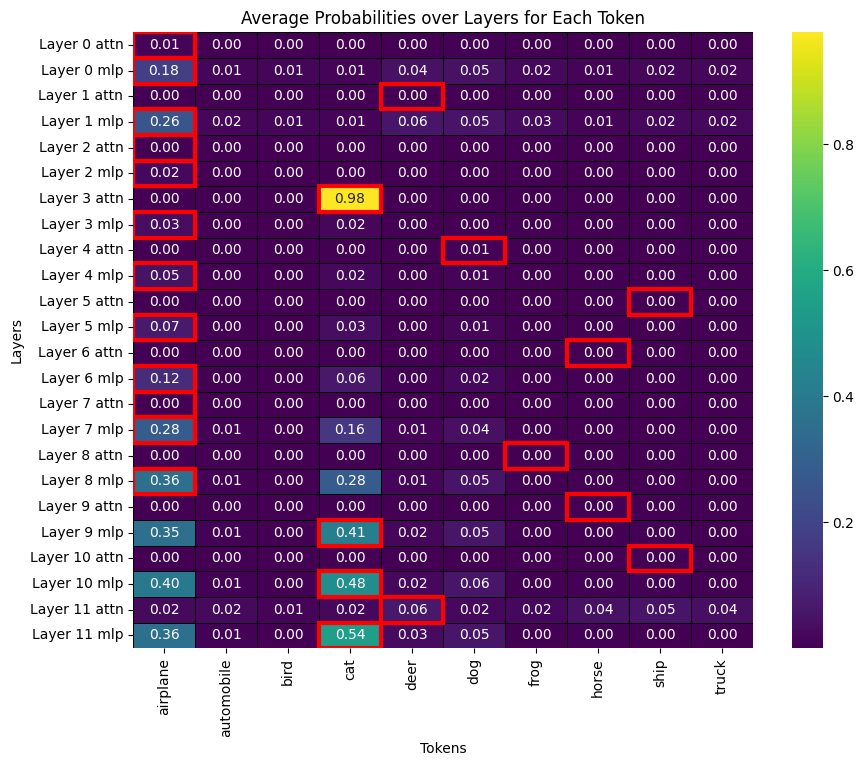

320  airplane
Model predicts 54.274851% chance answer is cat
airplane, 0.01
airplane, 0.18
?, 0.00
airplane, 0.26
3, 0.00
airplane, 0.02
cat, 0.98
airplane, 0.03
dog, 0.01
airplane, 0.05
<|endoftext|>, 0.00
airplane, 0.07
cat, 0.77
airplane, 0.12
\n, 0.21
airplane, 0.28
3, 0.18
airplane, 0.36
The, 0.68
cat, 0.41
in, 0.05
cat, 0.48
',, 0.24
cat, 0.54


In [8]:
logit_look(prompt_index=2, row=1, column=2, print_prompt=True, plot=False)

In [101]:
print(prompts[0])
for i in range(3):
    for j in range(3):
        print(i, j)
        logit_look(prompt_index=0, row=i, column=j, print_prompt=False, plot=False)

| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row {row}, column {column}? A: 

0 0
1, 0.01
?, 0.00
Each, 0.00
deer, 0.99
bird, 0.01
in, 0.62
bird, 1.00
\n, 0.03
., 0.11
The, 0.00
?, 0.08
,, 0.15
0 1
1, 0.01
?, 0.00
from, 0.00
cat, 0.91
cat, 0.92
in, 0.06
bird, 1.00
Each, 0.08
., 0.82
The, 0.00
?, 0.17
',, 0.19
0 2
1, 0.01
?, 0.00
Each, 0.00
bird, 1.00
']., 0.00
in, 0.03
bird, 1.00
\n, 0.11
?, 0.08
cell, 0.46
object, 0.01
deer, 0.21
1 0
1, 0.01
?, 0.00
bird, 0.00
deer, 0.99
object, 0.00
<|endoftext|>, 0.00
bird, 0.99
automobile, 0.45
horse, 0.02
The, 0.41
|, 0.01
deer, 0.21
1 1
1, 0.01
?, 0.00
size, 0.00
cat, 1.00
dog, 0.09
<|endoftext|>, 0.00
bird, 1.00
automobile, 0.34
The, 0.43
The, 0.10
object, 0.02
deer, 0.13
1 2
1, 0.01
?, 0.00
3, 0.00
cat, 0.90
']., 0.00
in, 0.00
bird, 1.00
\n, 0.18
The, 0.52
The, 0.78
in, 0.03
deer, 0.12
2 0
1, 0.01
?, 0.00
bird, 

| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row 0, column 1? A: 



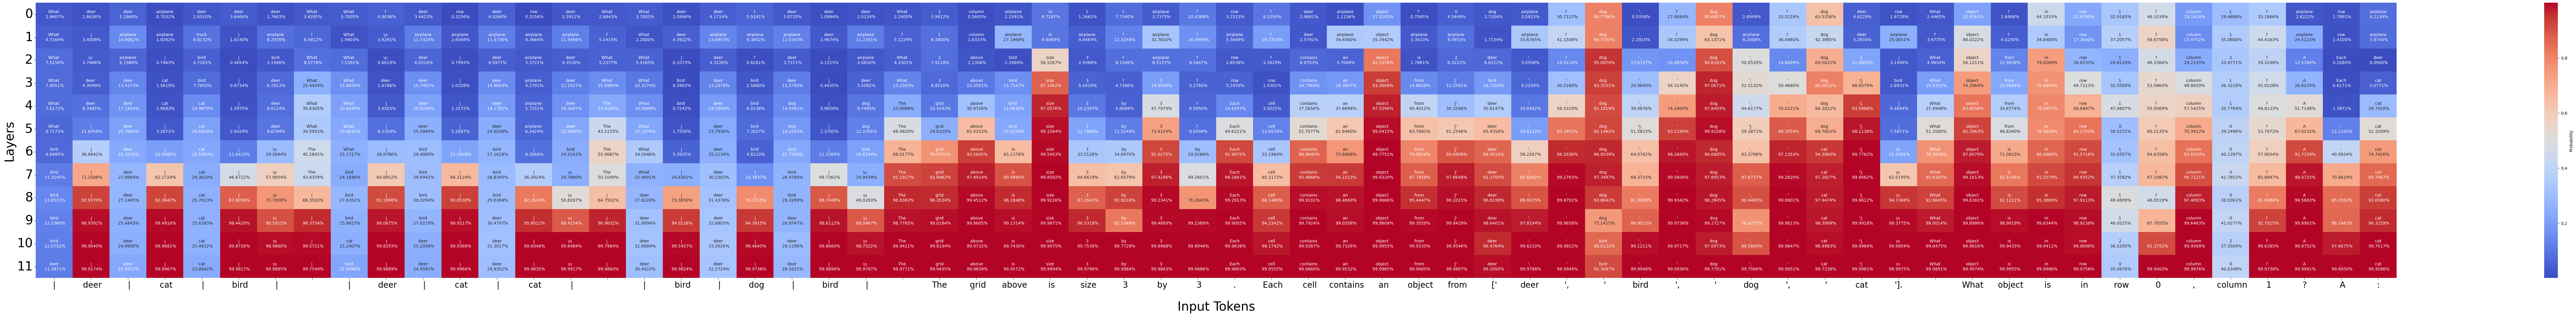

Model predicts 99.958557% chance answer is cat
airplane, 0.08
airplane, 0.08
deer, 0.00
cat, 0.05
cat, 0.29
cat, 0.52
cat, 0.75
cat, 0.86
cat, 0.94
cat, 0.96
cat, 1.00
cat, 1.00


In [66]:
logit_look(prompt_index=0, row=0, column=1)

In [ ]:
logit_look(prompt_index=0, row=0, column=0)

| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row 0, column 0? A: 



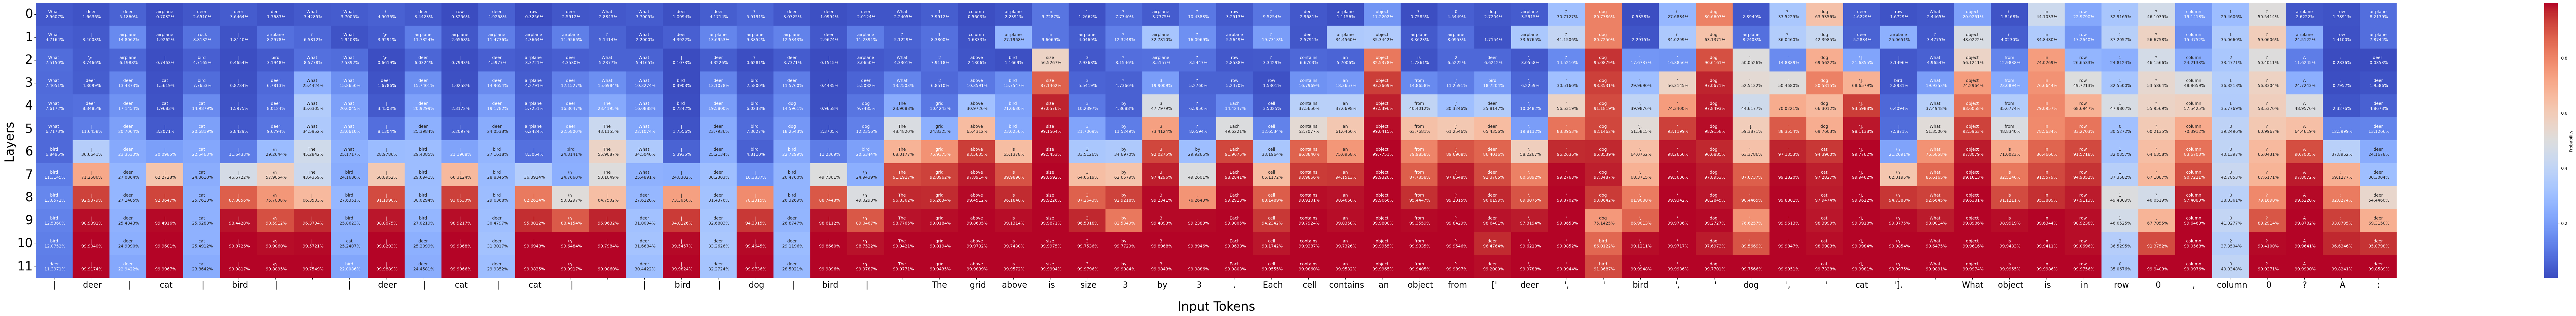

Model predicts 99.858934% chance answer is deer
airplane, 0.08
airplane, 0.08
deer, 0.00
deer, 0.02
deer, 0.05
deer, 0.13
deer, 0.24
deer, 0.30
deer, 0.54
deer, 0.69
deer, 0.95
deer, 1.00


In [67]:
logit_look(prompt_index=0, row=0, column=0)